In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
def hypo(x, k, b):
    return np.dot(k,x) + b

In [3]:
def actualYGen(x, k, b):
    return k*x + b + np.random.randn(x.shape[0])

In [4]:
#MSE cost function
def costFun(theta, x, y):
    try:
        m = len(y)
    except TypeError:
        m = 1
    y_ = hypo(x, theta[0], theta[1])
    cost = 1/m * np.sum((y_ - y)**2)
    dk = 1/m *np.sum(-(2 * x)*(y - (y_)))
    db = 1/m * np.sum(-2*(y-y_))
    grads = np.zeros(2)
    grads[0] = dk
    grads[1] = db
    return (cost, grads.flatten())

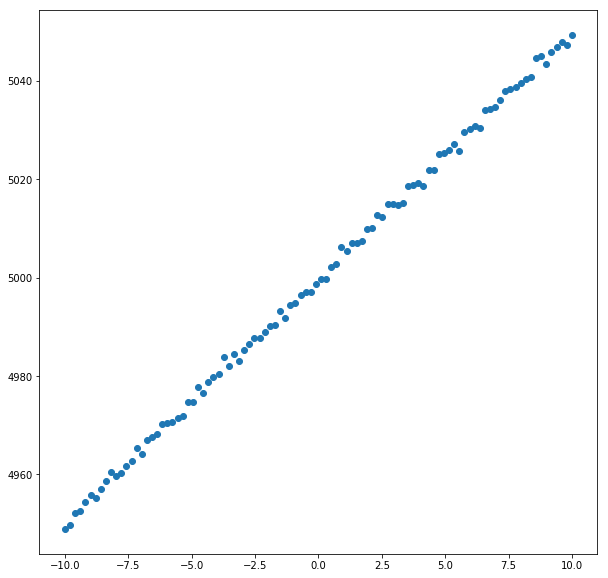

In [5]:
x = np.linspace(-10, 10, 100)
kOriginal = 5
bOriginal = 5000
y = actualYGen(x, kOriginal, bOriginal)
plt.figure(figsize=(10,10))
plt.scatter(x, y)

Text(0,0.5,'b')

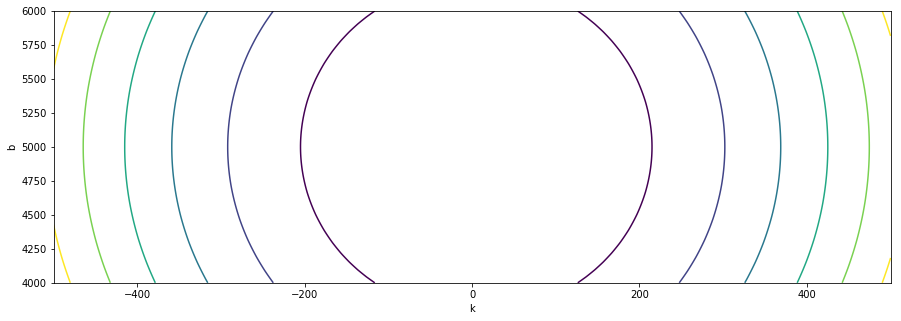

In [6]:
k = np.linspace(-500, 500, 100)
b = np.linspace(4000, 6000, 100)
kk, bb = np.meshgrid(k, b)

heightVal = np.zeros_like(kk)

for i in range(len(k)):
    for j in range(len(b)):
        #print('k:' + str(i))
        #print('b:' + str(j))
        heightVal[j, i] = costFun((k[i], b[j]), x, y)[0]
        #print(heightVal[i, j])
plt.figure(figsize=(15, 5))
plt.contour(kk, bb, heightVal)
plt.xlabel('k')
plt.ylabel('b')

Check minimum

In [7]:
initial = [100, -100]
options={'disp': True, 'gtol': 1e-6}
theta = minimize(costFun, initial, method='CG',options=options, args = (x, y), jac=True).x
theta

Optimization terminated successfully.
         Current function value: 0.829875
         Iterations: 4
         Function evaluations: 13
         Gradient evaluations: 13


array([  4.99653553e+00,   4.99991513e+03])

Check minimum complete

SGD

In [8]:
def gdParamUpdate(alpha, k, b, grads):
    k = k - alpha * grads[0]
    b = b - alpha * grads[1]
    return k, b

In [9]:
def sgdOptimize(x, y, k, b, alpha, steps):
    gdDict = {'k':[], 'b':[]}
    gdDict['k'].append(k)
    gdDict['b'].append(b)

    for i in range(steps):
        m = x.shape[0]
        randomIndex = np.random.randint(m)
        cost, grads = costFun([k, b], x[randomIndex], y[randomIndex])
        k, b = gdParamUpdate(alpha, k, b, grads)
        gdDict['k'].append(k)
        gdDict['b'].append(b)
    return gdDict

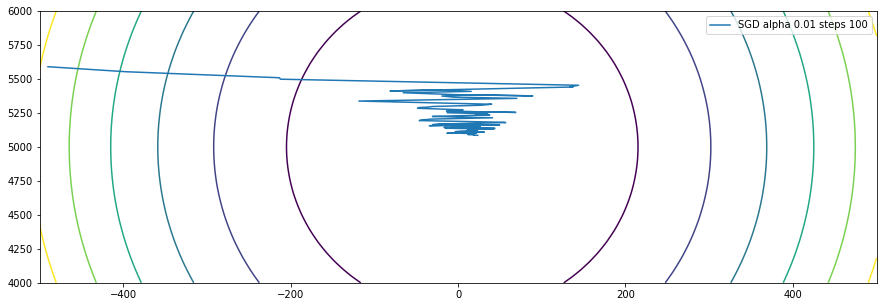

In [10]:
k = -490
b = 5590
gdAlpha = 0.01
gdSteps = 100
m = x.shape[0]

gdDict = sgdOptimize(x, y, k, b, gdAlpha, gdSteps)
    
plt.figure(figsize=(15, 5))
plt.contour(kk, bb, heightVal)
plt.plot(gdDict['k'], gdDict['b'], label = 'SGD alpha ' + str(gdAlpha) + ' steps '+ str(gdSteps))

plt.legend(loc = 0)

Momentum

In [11]:
def gdMomentum(alpha, beta, kPrev, bPrev, VdkPrev, VdbPrev, grads, iteration):
    if iteration == 0:
        Vdk = 0
        Vdb = 0
    else:
        #dk = 0.6*kPrev - 90
        #db = 3* bPrev + 15
        dk = grads[0]
        db = grads[1]
        Vdk = beta * VdkPrev + (1 - beta) * dk
        Vdb = beta * VdbPrev + (1 - beta) * db
    k = kPrev - alpha * VdkPrev
    b = bPrev - alpha * VdbPrev
    return k, b, Vdk, Vdb

In [12]:
def momentumOptimize(x, y, k, b, alpha, beta, steps):
    gdMomentumDict = {'k':[], 'b':[]}
    gdMomentumDict['k'].append(k)
    gdMomentumDict['b'].append(b)
    VdDict = {'Vdk':[0], 'Vdb':[0]}

    for i in range(steps):
        #print(i)
        #print(gdDict['b'][i])
        m = x.shape[0]
        randomIndex = np.random.randint(m)
        cost, grads = costFun([gdMomentumDict['k'][i], gdMomentumDict['b'][i]], x[randomIndex], y[randomIndex])
        k, b, Vdk, Vdb = gdMomentum(alpha, beta, gdMomentumDict['k'][i], gdMomentumDict['b'][i], VdDict['Vdk'][i], VdDict['Vdb'][i], grads, i)
        gdMomentumDict['k'].append(k)
        gdMomentumDict['b'].append(b)
        VdDict['Vdk'].append(Vdk)
        VdDict['Vdb'].append(Vdb)
    return gdMomentumDict

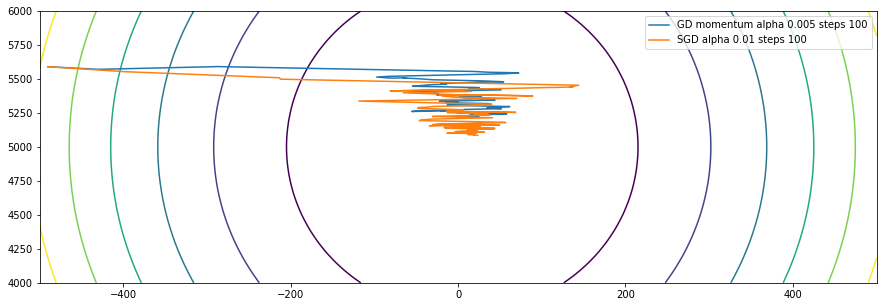

In [13]:
k = -490
b = 5590
momentumAlpha = 0.005
momentumBeta = 0.1
momentumSteps = 100

gdMomentumDict = momentumOptimize(x, y, k, b, momentumAlpha, momentumBeta, momentumSteps)
    
plt.figure(figsize=(15, 5))
plt.contour(kk, bb, heightVal)
plt.plot(gdMomentumDict['k'], gdMomentumDict['b'], label = 'GD momentum alpha ' + str(momentumAlpha) + ' steps '+ str(momentumSteps))
plt.plot(gdDict['k'], gdDict['b'], label = 'SGD alpha ' + str(gdAlpha) + ' steps '+ str(gdSteps))

plt.legend(loc = 0)

RMSProp

In [14]:
def RMSProp(alpha, beta, kPrev, bPrev, SdkPrev, SdbPrev, iteration, grads, epsilon =10e-9):
    dk = grads[0]
    db = grads[1]
    if iteration == 0:
        Sdk = 0
        Sdb = 0
        k = kPrev
        b = bPrev
    else:        
        Sdk = beta * SdkPrev + (1 - beta) * dk**2
        Sdb = beta * SdbPrev + (1 - beta) * db**2
        k = kPrev - alpha * dk/(np.sqrt(Sdk) + epsilon)
        b = bPrev - alpha * db/(np.sqrt(Sdb) + epsilon)
    return k, b, Sdk, Sdb

In [15]:
def RMSPropOptimize(x, y, k, b, alpha, beta, steps):
    RMSPropDict = {'k':[], 'b':[]}
    RMSPropDict['k'].append(k)
    RMSPropDict['b'].append(b)
    SdDict = {'Sdk':[0], 'Sdb':[0]}

    for i in range(steps):
        #print(i)
        #print(gdDict['b'][i])
        m = x.shape[0]
        randomIndex = np.random.randint(m)
        cost, grads = costFun([RMSPropDict['k'][i], RMSPropDict['b'][i]], x[randomIndex], y[randomIndex])
        k, b, Sdk, Sdb = RMSProp(alpha, beta, RMSPropDict['k'][i], RMSPropDict['b'][i], SdDict['Sdk'][i], SdDict['Sdb'][i], i, grads)
        RMSPropDict['k'].append(k)
        RMSPropDict['b'].append(b)
        SdDict['Sdk'].append(Sdk)
        SdDict['Sdb'].append(Sdb)
    return RMSPropDict

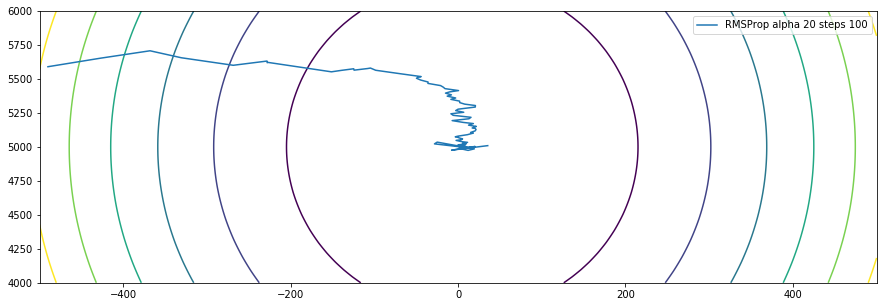

In [16]:
k = -490
b = 5590
RMSAlpha = 20
RMSBeta = 0.9
RMSPropSteps = 100

RMSPropDict = RMSPropOptimize(x, y, k, b, RMSAlpha, RMSBeta, RMSPropSteps)
    
plt.figure(figsize=(15, 5))
plt.contour(kk, bb, heightVal)
plt.plot(RMSPropDict['k'], RMSPropDict['b'], label = 'RMSProp alpha ' + str(RMSAlpha)+ ' steps ' + str(RMSPropSteps))

plt.legend(loc = 0)

Adam

In [17]:
def Adam(alpha, beta1, beta2, kPrev, bPrev, SdkPrev, SdbPrev, VdkPrev, VdbPrev, iteration, grads, epsilon = 1e-8):
    if iteration == 0:
        Vdk = 0
        Vdb = 0
        Sdk = 0
        Sdb = 0
        k = kPrev
        b = bPrev
        #kCorrected = k
        #bCorrected = b
        return k, b, Vdk, Vdb, Sdk, Sdb#, kCorrected, bCorrected
    else:
        dk = grads[0]
        db = grads[1]
        Vdk = beta1 * VdkPrev + (1 - beta1) * dk
        Vdb = beta1 * VdbPrev + (1 - beta1) * db
        Sdk = beta2 * SdkPrev + (1 - beta2) * dk**2
        Sdb = beta2 * SdbPrev + (1 - beta2) * db**2
        
        VdkCorrected = Vdk/(1 - beta1**iteration)
        VdbCorrected = Vdb/(1 - beta1**iteration)
        SdkCorrected = Sdk/(1 - beta2**iteration)
        SdbCorrected = Sdb/(1 - beta2**iteration)
        
        k = kPrev - alpha * VdkCorrected/(np.sqrt(SdkCorrected) + epsilon)
        b = bPrev - alpha * VdbCorrected/(np.sqrt(SdbCorrected) + epsilon)
        return k, b, Vdk, Vdb, Sdk, Sdb#, kCorrected, bCorrected

In [18]:
def adamOptimize(k, b, alpha, beta1, beta2, steps):
    AdamDict = {'k':[], 'b':[]}
    AdamDict['k'].append(k)
    AdamDict['b'].append(b)
    SdDict = {'Sdk':[0], 'Sdb':[0]}
    VdDict = {'Vdk':[0], 'Vdb':[0]}

    for i in range(steps):
        #print(i)
        #print(gdDict['b'][i])
        m = x.shape[0]
        randomIndex = np.random.randint(m)
        cost, grads = costFun([AdamDict['k'][i], AdamDict['b'][i]], x[randomIndex], y[randomIndex])
        
        k, b, Vdk, Vdb, Sdk, Sdb = Adam(alpha, beta1, beta2, AdamDict['k'][i], AdamDict['b'][i], SdDict['Sdk'][i], SdDict['Sdb'][i], VdDict['Vdk'][i], VdDict['Vdb'][i], i, grads)
        AdamDict['k'].append(k)
        AdamDict['b'].append(b)
        SdDict['Sdk'].append(Sdk)
        SdDict['Sdb'].append(Sdb)
        VdDict['Vdk'].append(Vdk)
        VdDict['Vdb'].append(Vdb)
    return AdamDict

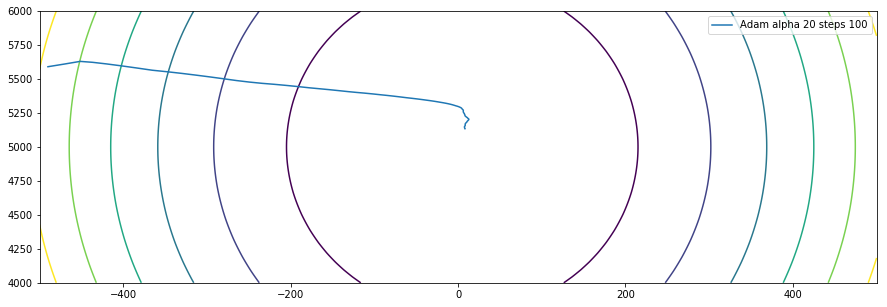

In [19]:
k = -490
b = 5590
adamAlpha = 20
beta1 = 0.9
beta2 = 0.999
adamSteps = 100

AdamDict = adamOptimize(k, b, adamAlpha, beta1, beta2, adamSteps)
    
plt.figure(figsize=(15, 5))
plt.contour(kk, bb, heightVal)
plt.plot(AdamDict['k'], AdamDict['b'], label = 'Adam alpha '+ str(adamAlpha)+ ' steps ' + str(adamSteps))

plt.legend(loc = 0)

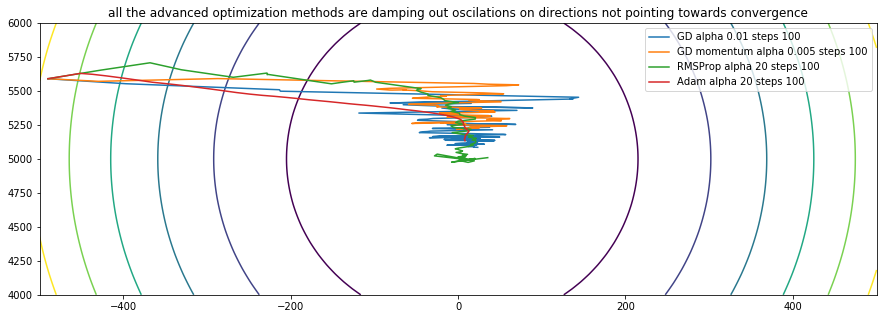

In [20]:
plt.figure(figsize=(15, 5))
plt.contour(kk, bb, heightVal)
plt.plot(gdDict['k'], gdDict['b'], label = 'GD alpha ' + str(gdAlpha) + ' steps '+ str(gdSteps))
plt.plot(gdMomentumDict['k'], gdMomentumDict['b'], label = 'GD momentum alpha ' + str(momentumAlpha) + ' steps '+ str(momentumSteps))
plt.plot(RMSPropDict['k'], RMSPropDict['b'], label = 'RMSProp alpha ' + str(RMSAlpha)+ ' steps ' + str(RMSPropSteps))
plt.plot(AdamDict['k'], AdamDict['b'], label = 'Adam alpha '+ str(adamAlpha)+ ' steps ' + str(adamSteps))

plt.title('all the advanced optimization methods are damping out oscilations on directions not pointing towards convergence')

plt.legend(loc = 0)